In [1]:
# Data processing libraries
import pandas as pd
import numpy as np
import itertools

# Database libraries
import psycopg2

# Stats libraries
from tableone import TableOne
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

# Image libraries
# https://jakevdp.github.io/pdvega/
# jupyter nbextension enable vega3 --py --sys-prefix
import matplotlib.pyplot as plt
import pdvega 
%matplotlib inline

In [2]:
# Create a database connection
user = 'team_j'
password = 'challenge_j'
host = 'hst953.csail.mit.edu'
dbname = 'mimic'
schema = 'mimiciii'

In [3]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=password)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

In [4]:
# Run query and assign the results to a Pandas DataFrame
# Requires the icustay_detail view from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/demographics
# And the OASIS score from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores
query = \
"""
WITH first_icu AS (
    SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admittime admittime_hospital, 
      i.dischtime dischtime_hospital, i.los_hospital, i.age, i.admission_type, 
      i.hospital_expire_flag, i.intime intime_icu, i.outtime outtime_icu, i.los_icu, i.hospstay_seq, i.icustay_seq,
      s.first_careunit,s.last_careunit,s.first_wardid, s.last_wardid
    FROM icustay_detail i
    LEFT JOIN icustays s
    ON i.icustay_id = s.icustay_id
    WHERE i.age >= 50 AND i.age <= 60
)
SELECT f.*, o.icustay_expire_flag, o.oasis, o.oasis_prob
FROM first_icu f
LEFT JOIN oasis o
ON f.icustay_id = o.icustay_id;
"""

data = pd.read_sql_query(query,con)

In [5]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'age', 'admission_type',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'hospstay_seq', 'icustay_seq', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'icustay_expire_flag', 'oasis',
       'oasis_prob'],
      dtype='object')

In [6]:
data

,subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,age,admission_type,hospital_expire_flag,...,los_icu,hospstay_seq,icustay_seq,first_careunit,last_careunit,first_wardid,last_wardid,icustay_expire_flag,oasis,oasis_prob
0,292,179726,222505,F,2103-09-27 18:28:00,2103-09-28 15:44:00,0.8861,57.0273,URGENT,1,...,0.8854,1,1,MICU,MICU,12,12,1,48,0.486353
1,323,128132,206073,M,2119-09-21 20:34:00,2119-10-06 18:50:00,14.9278,56.7428,EMERGENCY,0,...,11.9999,2,1,MICU,MICU,12,12,0,31,0.097783
2,324,146127,285067,M,2199-10-16 01:11:00,2199-10-16 17:19:00,0.6722,54.9774,EMERGENCY,0,...,0.6528,1,1,TSICU,TSICU,33,33,0,25,0.048012
3,344,176203,238865,F,2154-11-12 20:53:00,2154-11-16 05:45:00,3.3694,58.1857,EMERGENCY,1,...,3.4836,1,1,MICU,MICU,15,15,1,23,0.037612
4,353,159730,265453,M,2148-06-15 11:04:00,2148-07-04 17:48:00,19.2806,58.8965,URGENT,0,...,2.1264,1,1,CSRU,CSRU,14,14,0,38,0.209226
5,354,131861,227646,M,2189-02-12 18:29:00,2189-03-02 14:09:00,17.8194,59.4558,EMERGENCY,0,...,6.4636,1,1,CCU,CSRU,57,14,0,37,0.188911
6,73,194730,284305,F,2170-12-22 00:12:00,2170-12-26 12:00:00,4.4917,57.5865,EMERGENCY,0,...,2.6794,1,1,CCU,CCU,57,57,0,22,0.033259
7,125,157348,268261,F,2179-02-14 21:23:00,2179-02-21 18:03:00,6.8611,50.9632,ELECTIVE,0,...,1.2281,1,1,CSRU,CSRU,15,15,0,36,0.170145
8,132,160192,267893,F,2115-05-06 21:53:00,2115-05-25 12:10:00,18.5951,56.2063,EMERGENCY,0,...,15.8681,1,1,SICU,SICU,23,23,0,31,0.097783
9,138,188284,254974,M,2133-12-21 23:52:00,2134-01-11 13:00:00,20.5472,50.1640,EMERGENCY,0,...,3.9687,2,1,SICU,SICU,57,57,0,25,0.048012


In [8]:
subj_rows = []
for i,subj_id in enumerate(data['subject_id']):
    if subj_id == 13033: # just for a test
        subj_rows.append(i)

In [9]:
m_icu_id = (0,0)
for row_i in subj_rows:
    d = data['icustay_seq'][row_i]
    if d > m_icu_id[1]:
        m_icu_id = (row_i,d)
        
m_icu_id

(0, 0)

In [10]:
def create_icu_table():
    icu_table = {}
    sub_m = {}
    for i,subj_id in enumerate(data['subject_id']):    
        if subj_id not in sub_m:
            sub_m[subj_id] = []
        sub_m[subj_id].append(i)
    
    for subj,subj_rows in sub_m.items():
        for row_i in subj_rows:
            d = data['icustay_seq'][row_i]
            if d > icu_table.get(subj,(0,0))[1]:
                icu_table[subj]=(row_i,d)
                
    return icu_table

In [11]:
it = create_icu_table()

In [12]:
target_rows = []
for row_i, _ in it.values():
    target_rows.append(row_i)

In [13]:
data.iloc[target_rows]

,subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,age,admission_type,hospital_expire_flag,...,los_icu,hospstay_seq,icustay_seq,first_careunit,last_careunit,first_wardid,last_wardid,icustay_expire_flag,oasis,oasis_prob
9233,81920,157818,280897,M,2201-03-31 12:00:00,2201-04-04 14:15:00,4.0938,53.2428,ELECTIVE,0,...,0.9774,1,1,CSRU,CSRU,15,15,0,22,0.033259
1648,16389,171935,242413,F,2160-12-19 18:38:00,2160-12-29 15:27:00,9.8674,52.4824,EMERGENCY,0,...,1.0388,1,1,MICU,MICU,15,15,0,20,0.025967
7312,32774,164288,273339,M,2127-11-04 05:05:00,2127-11-07 17:51:00,3.5319,53.0859,EMERGENCY,0,...,2.8859,1,1,MICU,MICU,23,23,0,26,0.054187
6207,16392,164309,232749,F,2185-03-18 00:09:00,2185-03-30 17:15:00,12.7125,53.2524,EMERGENCY,0,...,8.6675,1,1,SICU,MICU,23,15,0,37,0.188911
25,11,194540,229441,F,2178-04-16 06:18:00,2178-05-11 19:00:00,25.5292,50.1483,EMERGENCY,0,...,1.5844,1,1,SICU,SICU,57,57,0,29,0.077479
7298,31643,117953,260704,M,2158-09-11 17:48:00,2158-09-14 11:50:00,2.7514,56.1265,EMERGENCY,0,...,1.1635,1,1,TSICU,TSICU,14,14,0,22,0.033259
26,18,188822,298129,M,2167-10-02 11:18:00,2167-10-04 16:15:00,2.2063,50.8416,EMERGENCY,0,...,1.2885,1,1,CCU,CCU,7,7,0,23,0.037612
8283,65555,143872,213945,F,2167-02-14 11:54:00,2167-02-16 05:30:00,1.7333,57.5303,EMERGENCY,1,...,1.8479,1,1,MICU,MICU,50,50,1,48,0.486353
2743,32789,154245,249640,F,2115-11-29 07:15:00,2115-12-01 19:35:00,2.5139,54.8850,ELECTIVE,0,...,1.2157,1,1,CSRU,CSRU,12,12,0,51,0.581248
1649,16406,112560,297980,M,2183-07-16 13:00:00,2183-07-19 13:45:00,3.0313,59.7427,EMERGENCY,0,...,2.1716,1,1,MICU,MICU,12,12,0,24,0.042509


In [14]:
len(data['subject_id'].unique())

6827

In [15]:
#writer = pd.ExcelWriter('max_icu_stay.xlsx')
#data.iloc[target_rows].to_excel(writer,'Sheet1')
#writer.save()

In [16]:
item = 228232
query = \
"""
    SELECT c.subject_id, c.hadm_id, c.icustay_id, c.charttime,
    c.cgid,g.label   
    FROM chartevents c
    LEFT JOIN caregivers g
    ON c.cgid = g.cgid
    WHERE c.icustay_id = """+str(item)+"""
"""

data_cg = pd.read_sql_query(query,con)

In [17]:
data_cg['cgid'].value_counts()

18765    1160
15443     672
14418     637
15816     552
19947     442
17461     340
14427     285
15331     174
16047      26
21570      23
16284      20
14077      12
17485       2
21347       2
20389       1
Name: cgid, dtype: int64

In [18]:
def get_cgid_label(df, cgid):
    return df.loc[df['cgid'] == cgid]['label'].values[0]

In [19]:
get_cgid_label(data_cg,18765)

'MD'

In [20]:
[get_cgid_label(data_cg,idxx) for idxx in data_cg['cgid'].value_counts().index]

['MD',
 'RN',
 'RN',
 'RN',
 'RN',
 'RN',
 'RN',
 None,
 'RN',
 None,
 'RN',
 None,
 'RN',
 'PCT',
 'RRT']

In [21]:
query = \
"""
    SELECT g.label   
    FROM caregivers g
    WHERE g.label = 'RN' OR g.label = 'MD' OR g.label = 'Res' OR g.label = 'RO' OR g.label = 'MDs'
"""

data_cglabel = pd.read_sql_query(query,con)

In [22]:
data_cglabel['label'].value_counts()

RO     1658
MD     1380
Res    1238
RN     1185
MDs     226
Name: label, dtype: int64

In [23]:
def get_measure_info(subj_icustay_id):
    
    #Check type for safety
    if type(subj_icustay_id)!= int:
        raise TypeError
        
    query = \
    """
        SELECT c.icustay_id,c.cgid,g.label   
        FROM chartevents c
        LEFT JOIN caregivers g
        ON c.cgid = g.cgid
        WHERE c.icustay_id = """+str(subj_icustay_id)+"""
    """

    data_cg = pd.read_sql_query(query,con)
    
    mea_list = [(get_cgid_label(data_cg,idxx),v) for idxx, v in data_cg['cgid'].value_counts().items()]
    
    #clinic_types = ['RO','MD','Res','RN','MDs']
    counts = {"RO":[0,0],"MDs":[0,0],"RN":[0,0],"OTH":[0,0]}
    
    total_meas = 0
    
    for m_inst, m_visit_count in mea_list:
        
        total_meas = total_meas + m_visit_count
        
        if (m_inst == None):
            counts["OTH"][0] = counts["OTH"][0] + 1
            counts["OTH"][1] = counts["OTH"][1] + m_visit_count

        else:
            cmp = m_inst.upper()
            if (cmp == "RO"):
                counts["RO"][0] = counts["RO"][0] + 1
                counts["RO"][1] = counts["RO"][1] + m_visit_count
            elif (cmp == "MDS"):
                counts["MDs"][0] = counts["MDs"][0] + 1
                counts["MDs"][1] = counts["MDs"][1] + m_visit_count
            elif (cmp == "MD"):
                counts["MDs"][0] = counts["MDs"][0] + 1
                counts["MDs"][1] = counts["MDs"][1] + m_visit_count
            elif (cmp == "RES"):
                counts["MDs"][0] = counts["MDs"][0] + 1
                counts["MDs"][1] = counts["MDs"][1] + m_visit_count
            elif (cmp == "RN"):
                counts["RN"][0] = counts["RN"][0] + 1
                counts["RN"][1] = counts["RN"][1] + m_visit_count
            else:
                counts["OTH"][0] = counts["OTH"][0] + 1
                counts["OTH"][1] = counts["OTH"][1] + m_visit_count
            
    return (counts,total_meas)
        
    

In [24]:
get_measure_info(228232)

({'MDs': [1, 1160], 'OTH': [5, 212], 'RN': [9, 2976], 'RO': [0, 0]}, 4348)

In [25]:
data_mro = data.iloc[target_rows]

In [26]:
import datetime

In [27]:
data_slices = []
cur_b = 0
width = 29
while cur_b < len(data_mro):   
    s = datetime.datetime.now()
    d_info = data_mro['icustay_id'][cur_b:cur_b + width].apply(get_measure_info)
    data_slices.append(d_info)
    e = datetime.datetime.now()
    print((e-s).total_seconds(), cur_b)
    cur_b = cur_b + width + 1

57.871504 0
53.026573 30
74.20828 60
58.453663 90
84.72399 120
73.379976 150
74.145481 180
69.006481 210
75.297858 240
62.036299 270
49.530489 300
82.419388 330
80.361899 360
61.821284 390
51.5968 420
61.998933 450
93.611282 480
67.154166 510
88.947505 540
169.38302 570
88.930272 600
42.806503 630
46.417513 660
67.357822 690
79.994033 720
52.928131 750
46.227089 780
54.802969 810
70.053074 840
183.557121 870
131.226266 900
104.533777 930
43.187123 960
75.054512 990
60.542758 1020
69.612086 1050
156.5913 1080
64.90165 1110
54.409307 1140
53.517207 1170
43.503014 1200
61.904123 1230
57.033028 1260
144.731571 1290
169.570357 1320
44.550524 1350
64.853758 1380
34.92792 1410
40.879468 1440
30.936176 1470
39.213081 1500
45.397786 1530
46.12286 1560
53.105847 1590
58.132912 1620
47.75744 1650
56.250596 1680
45.405041 1710
30.211561 1740
31.462636 1770
29.604185 1800
31.832525 1830
44.483993 1860
37.922335 1890
46.381502 1920
46.865898 1950
53.901988 1980
65.601399 2010
40.114201 2040
37.99714

In [28]:
len(data_mro)

6827

In [29]:
data_slices

[9233    ({'RO': [0, 0], 'OTH': [4, 1056], 'MDs': [0, 0...
 1648    ({'RO': [0, 0], 'OTH': [5, 55], 'MDs': [0, 0],...
 7312    ({'RO': [0, 0], 'OTH': [6, 143], 'MDs': [0, 0]...
 6207    ({'RO': [0, 0], 'OTH': [3, 2458], 'MDs': [0, 0...
 25      ({'RO': [0, 0], 'OTH': [5, 88], 'MDs': [0, 0],...
 7298    ({'RO': [0, 0], 'OTH': [4, 256], 'MDs': [0, 0]...
 26      ({'RO': [0, 0], 'OTH': [4, 122], 'MDs': [0, 0]...
 8283    ({'RO': [0, 0], 'OTH': [6, 750], 'MDs': [0, 0]...
 2743    ({'RO': [0, 0], 'OTH': [4, 258], 'MDs': [0, 0]...
 1649    ({'RO': [0, 0], 'OTH': [3, 1229], 'MDs': [0, 0...
 6208    ({'RO': [0, 0], 'OTH': [3, 81], 'MDs': [0, 0],...
 4643    ({'RO': [0, 0], 'OTH': [6, 1310], 'MDs': [0, 0...
 6209    ({'RO': [0, 0], 'OTH': [6, 589], 'MDs': [0, 0]...
 2744    ({'RO': [0, 0], 'OTH': [7, 347], 'MDs': [0, 0]...
 2745    ({'RO': [0, 0], 'OTH': [7, 1335], 'MDs': [0, 0...
 6210    ({'RO': [0, 0], 'OTH': [8, 303], 'MDs': [0, 0]...
 4388    ({'RO': [0, 0], 'OTH': [4, 183], 'MDs': [0, 0].

(array([622., 612., 639., 649., 652., 687., 681., 734., 776., 775.]),
 array([50.0015, 51.0012, 52.0009, 53.0006, 54.0003, 55.    , 55.9997,
        56.9994, 57.9991, 58.9988, 59.9985]),
 <a list of 10 Patch objects>)

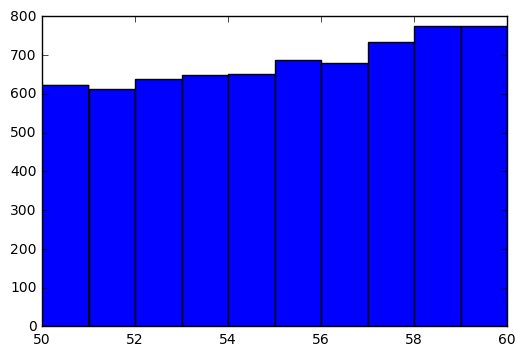

In [30]:
plt.hist(data_mro['age'])

140.8

In [31]:
import pickle # python serialization

In [32]:
pickle.dump(data_slices,open( "save.p", "wb" ))